In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, SimpleRNN
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import History, LearningRateScheduler
from tensorflow.keras.metrics import mean_absolute_error
from tqdm import tqdm
print(tf.__version__)

2.3.0


In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [13]:
def windowed_dataset(series: np.ndarray, window_size: int, batch_size: int, shuffle_buffer: int) -> tf.raw_ops.PrefetchDataset:
  dataset: tf.raw_ops.TensorSliceDataset = tf.data.Dataset.from_tensor_slices(series)
  dataset: tf.raw_ops.WindowDataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset: tf.raw_ops.FlatMapDataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset: tf.raw_ops.MapDataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset: tf.raw_ops.PrefetchDataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [14]:
clear_session()
set_seed(51)
np.random.seed(51)

train_set: tf.raw_ops.PrefetchDataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = Sequential([
  Lambda(function=lambda x: tf.expand_dims(x, axis=-1), name="lambda_1", input_shape=[None]),
  SimpleRNN(units=40, return_sequences=True, name="rnn_1"),
  SimpleRNN(units=40, return_sequences=False, name="rnn_2"),
  Dense(units=1, name="dense_3"),
  Lambda(function=lambda x: x * 100.0, name="lambda_3")
])

model.compile(
    loss=Huber(),
    optimizer=SGD(lr=1e-8, momentum=0.9),
    metrics=["mae"]
)
history: History = model.fit(
    train_set, 
    epochs=100, 
    workers=-1,
    use_multiprocessing=True,
    callbacks=[
        LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    ]
)

Epoch 1/100
8/8 [==============================] - 0s 38ms/step - loss: 195.5726 - mae: 196.0726
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 194.7820 - mae: 195.2820
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 193.5109 - mae: 194.0109
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 191.9080 - mae: 192.4080
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 187.8582 - mae: 188.3582
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 185.3786 - mae: 185.8786
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 182.5483 - mae: 183.0483
Epoch 9/100
8/8 [==============================] - 0s 18ms/step - loss: 179.3126 - mae: 179.8126
Epoch 10/100
8/8 [==============================] - 0s 19ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [===========

8/8 [==============================] - 0s 18ms/step - loss: 24.9573 - mae: 25.4544
Epoch 88/100
8/8 [==============================] - 0s 19ms/step - loss: 26.5580 - mae: 27.0563
Epoch 89/100
8/8 [==============================] - 0s 18ms/step - loss: 19.8189 - mae: 20.3140
Epoch 90/100
8/8 [==============================] - 0s 17ms/step - loss: 43.0915 - mae: 43.5908
Epoch 91/100
8/8 [==============================] - 0s 19ms/step - loss: 41.2442 - mae: 41.7408
Epoch 92/100
8/8 [==============================] - 0s 18ms/step - loss: 21.1443 - mae: 21.6395
Epoch 93/100
8/8 [==============================] - 0s 18ms/step - loss: 28.2956 - mae: 28.7918
Epoch 94/100
8/8 [==============================] - 0s 18ms/step - loss: 55.1593 - mae: 55.6573
Epoch 95/100
8/8 [==============================] - 0s 18ms/step - loss: 51.1783 - mae: 51.6769
Epoch 96/100
8/8 [==============================] - 0s 18ms/step - loss: 25.9593 - mae: 26.4553
Epoch 97/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

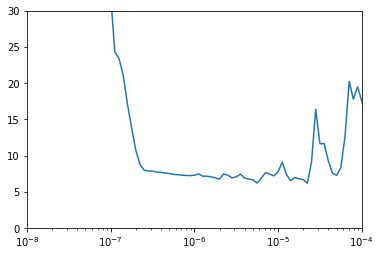

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [16]:
clear_session()
set_seed(51)
np.random.seed(51)

dataset: tf.raw_ops.PrefetchDataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = Sequential([
  Lambda(function=lambda x: tf.expand_dims(x, axis=-1), name="lambda_1", input_shape=[None]),
  SimpleRNN(units=40, return_sequences=True, name="rnn_1"),
  SimpleRNN(units=40, return_sequences=False, name="rnn_2"),
  Dense(units=1, name="dense_3"),
  Lambda(function=lambda x: x * 100.0, name="lambda_3")
])

model.compile(
    loss=Huber(),
    optimizer=SGD(lr=5e-5, momentum=0.9),
    metrics=["mae"]
)
history: History = model.fit(
    dataset,
    epochs=400,
    workers=-1,
    use_multiprocessing=True
)

Epoch 1/400
8/8 [==============================] - 0s 20ms/step - loss: 81.7535 - mae: 82.2534
Epoch 2/400
8/8 [==============================] - 0s 17ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 18ms/step - loss: 15.9200 - mae: 16.4144
Epoch 4/400
8/8 [==============================] - 0s 17ms/step - loss: 12.2879 - mae: 12.7813
Epoch 5/400
8/8 [==============================] - 0s 17ms/step - loss: 10.1498 - mae: 10.6401
Epoch 6/400
8/8 [==============================] - 0s 18ms/step - loss: 16.3471 - mae: 16.8423
Epoch 7/400
8/8 [==============================] - 0s 18ms/step - loss: 13.3997 - mae: 13.8916
Epoch 8/400
8/8 [==============================] - 0s 18ms/step - loss: 9.1609 - mae: 9.6506
Epoch 9/400
8/8 [==============================] - 0s 17ms/step - loss: 8.3295 - mae: 8.8214
Epoch 10/400
8/8 [==============================] - 0s 18ms/step - loss: 7.5424 - mae: 8.0293
Epoch 11/400
8/8 [==============================] - 0s 

Epoch 88/400
8/8 [==============================] - 0s 17ms/step - loss: 4.7132 - mae: 5.1925
Epoch 89/400
8/8 [==============================] - 0s 17ms/step - loss: 4.4703 - mae: 4.9486
Epoch 90/400
8/8 [==============================] - 0s 18ms/step - loss: 4.5727 - mae: 5.0527
Epoch 91/400
8/8 [==============================] - 0s 18ms/step - loss: 4.7817 - mae: 5.2612
Epoch 92/400
8/8 [==============================] - 0s 17ms/step - loss: 5.5608 - mae: 6.0454
Epoch 93/400
8/8 [==============================] - 0s 18ms/step - loss: 6.1177 - mae: 6.5982
Epoch 94/400
8/8 [==============================] - 0s 17ms/step - loss: 5.0869 - mae: 5.5666
Epoch 95/400
8/8 [==============================] - 0s 18ms/step - loss: 5.0169 - mae: 5.4964
Epoch 96/400
8/8 [==============================] - 0s 17ms/step - loss: 6.1342 - mae: 6.6206
Epoch 97/400
8/8 [==============================] - 0s 19ms/step - loss: 6.3349 - mae: 6.8206
Epoch 98/400
8/8 [==============================] - 0s 17ms/

8/8 [==============================] - 0s 18ms/step - loss: 5.8247 - mae: 6.3062
Epoch 175/400
8/8 [==============================] - 0s 18ms/step - loss: 4.9352 - mae: 5.4138
Epoch 176/400
8/8 [==============================] - 0s 17ms/step - loss: 4.7610 - mae: 5.2413
Epoch 177/400
8/8 [==============================] - 0s 19ms/step - loss: 4.4312 - mae: 4.9087
Epoch 178/400
8/8 [==============================] - 0s 17ms/step - loss: 5.4754 - mae: 5.9621
Epoch 179/400
8/8 [==============================] - 0s 18ms/step - loss: 4.6599 - mae: 5.1391
Epoch 180/400
8/8 [==============================] - 0s 17ms/step - loss: 4.4193 - mae: 4.8968
Epoch 181/400
8/8 [==============================] - 0s 17ms/step - loss: 5.0325 - mae: 5.5087
Epoch 182/400
8/8 [==============================] - 0s 17ms/step - loss: 4.3713 - mae: 4.8446
Epoch 183/400
8/8 [==============================] - 0s 19ms/step - loss: 4.6775 - mae: 5.1558
Epoch 184/400
8/8 [==============================] - 0s 17ms/ste

8/8 [==============================] - 0s 19ms/step - loss: 5.8362 - mae: 6.3187
Epoch 261/400
8/8 [==============================] - 0s 18ms/step - loss: 8.6843 - mae: 9.1751
Epoch 262/400
8/8 [==============================] - 0s 17ms/step - loss: 7.2961 - mae: 7.7816
Epoch 263/400
8/8 [==============================] - 0s 17ms/step - loss: 5.9946 - mae: 6.4753
Epoch 264/400
8/8 [==============================] - 0s 17ms/step - loss: 4.5916 - mae: 5.0681
Epoch 265/400
8/8 [==============================] - 0s 17ms/step - loss: 4.8403 - mae: 5.3211
Epoch 266/400
8/8 [==============================] - 0s 17ms/step - loss: 4.5235 - mae: 4.9985
Epoch 267/400
8/8 [==============================] - 0s 17ms/step - loss: 4.1783 - mae: 4.6523
Epoch 268/400
8/8 [==============================] - 0s 18ms/step - loss: 4.5205 - mae: 4.9995
Epoch 269/400
8/8 [==============================] - 0s 17ms/step - loss: 4.1774 - mae: 4.6526
Epoch 270/400
8/8 [==============================] - 0s 19ms/ste

8/8 [==============================] - 0s 17ms/step - loss: 5.6675 - mae: 6.1462
Epoch 347/400
8/8 [==============================] - 0s 17ms/step - loss: 5.7369 - mae: 6.2198
Epoch 348/400
8/8 [==============================] - 0s 17ms/step - loss: 5.5725 - mae: 6.0577
Epoch 349/400
8/8 [==============================] - 0s 17ms/step - loss: 4.8703 - mae: 5.3502
Epoch 350/400
8/8 [==============================] - 0s 17ms/step - loss: 4.2731 - mae: 4.7509
Epoch 351/400
8/8 [==============================] - 0s 17ms/step - loss: 4.3354 - mae: 4.8158
Epoch 352/400
8/8 [==============================] - 0s 19ms/step - loss: 4.3566 - mae: 4.8304
Epoch 353/400
8/8 [==============================] - 0s 18ms/step - loss: 4.5001 - mae: 4.9742
Epoch 354/400
8/8 [==============================] - 0s 17ms/step - loss: 4.7006 - mae: 5.1742
Epoch 355/400
8/8 [==============================] - 0s 17ms/step - loss: 5.8214 - mae: 6.3014
Epoch 356/400
8/8 [==============================] - 0s 17ms/ste

100%|████████████████████████████████████████████████████████████████████████████████| 1441/1441 [00:36<00:00, 39.69it/s]


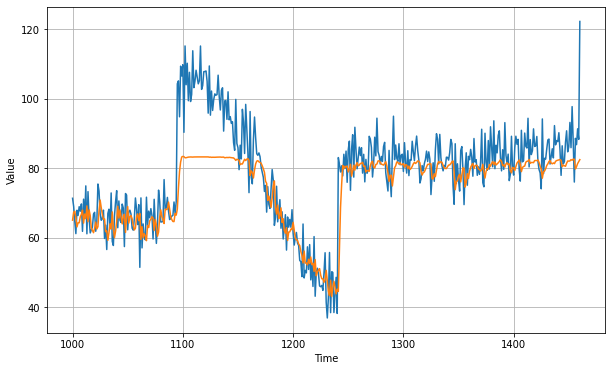

In [20]:
forecast=[]
for time in tqdm(range(len(series) - window_size)):
  forecast.append(model.predict(np.expand_dims(series[time:time + window_size], 0)))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [22]:
print(mean_absolute_error(x_valid, results).numpy())

6.6962333


<Figure size 432x288 with 0 Axes>

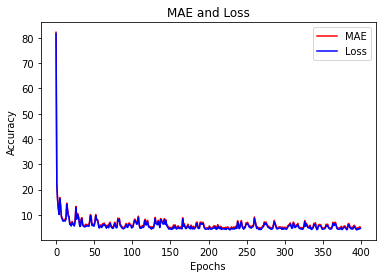

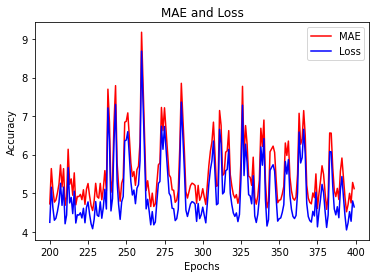

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()